## Adult Mouse Kidney Example Using iStar

### 1. Data Description
The dataset features FFPE mouse kidney tissue, sectioned and prepared on Visium Gene Expression slides using 10x Genomics protocols. It is referenced in the iStar paper and shown in Extended Data Fig. 10.

**Source**: The data originates from 10x Genomics: [Adult Mouse Kidney FFPE](https://www.10xgenomics.com/datasets/adult-mouse-kidney-ffpe-1-standard-1-3-0).

**Histology Image**: The full-resolution TIFF image from the input files is used as **`he-raw.tif`**. The image has a resolution of 27,443 pixels (width) × 25,260 pixels (height).

**Dataset Specifications**:   
- Number of spots: 3,124  
- Number of genes: 19,465  
- Pixel size (raw): 0.29 micrometers  
- Radius (raw): 94.33 pixels


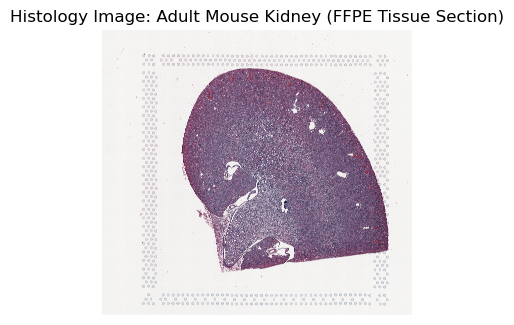

In [1]:
#| hide
from PIL import Image
import matplotlib.pyplot as plt

Image.MAX_IMAGE_PIXELS = None

he_raw_image = Image.open('he-raw.tif')

plt.figure(figsize=(6, 6))
plt.imshow(he_raw_image)
plt.axis('off') 
plt.title("Histology Image: Adult Mouse Kidney (FFPE Tissue Section)")
plt.show()


### 2. Image Preprocessing and Feature Embedding

**Pixel Size Setting**: The desired pixel size for the entire analysis was set to 0.5 micrometers, meaning each pixel covers an area of 0.5 × 0.5 micrometers².

**Scaled and Preprocessed Image**: The histology image was resized to a resolution of 16,128 pixels (width) × 14,848 pixels (height) and partitioned into 16 tiles for downstream processing.

**Feature Embedding**: 

Following the steps described in the iStar paper, the image embeddings were obtained with a shape of (928, 1008, 579):
- 928 × 1008: Subtiles from the scaled image resolution of 16,128 × 14,848 pixels, where 1008 pixels comes from dividing the width by 16 tiles (16,128 / 16 = 1008), and the height is proportionally 928.
- The 579 features consist of 192 high-level features, 384 low-level features, and 3 RGB channels for color information.

### 3. Mask

To identify the tissue regions containing meaningful spots for training the model, the features extracted from the image were clustered into 2 clusters using KMeans clustering, and small, disconnected regions with fewer than 20 connected pixels were relabeled or removed to ensure spatial coherence. The cluster with the highest variance in RGB values was selected as the foreground, creating a binary mask that highlights the foreground regions for future use.

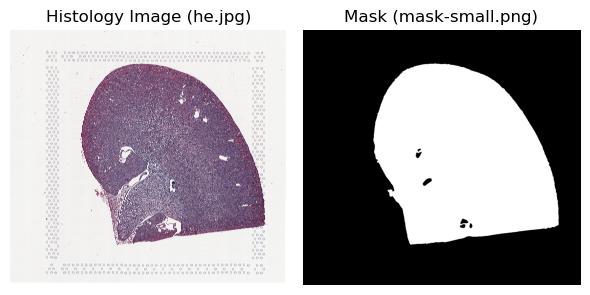

In [3]:
#| hide
he_image = Image.open('he.jpg')
mask = Image.open('mask-small.png')

plt.figure(figsize=(6, 3))

# the histology image
plt.subplot(1, 2, 1)
plt.imshow(he_image)
plt.axis('off')
plt.title("Histology Image (he.jpg)")

# the mask
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.title("Mask (mask-small.png)")

plt.tight_layout()  # Adjust layout for better spacing
plt.show()



### 4. Gene Expression Prediction

**Gene Selection for Model Training**: The union of the 1,000 most highly variable genes and 277 marker genes curated from the database Cell Type Selective Markers: RNA-seq Analysis of Mouse Whole Kidney (Clark et al., 2019) was selected for model training. The resulting 1,224 genes represent the number of output nodes in the output layer.

**Observed Spot-level and Predicted Gene Expression**: The following plots illustrate the observed gene expression from the sequencing-based ST platform used for model training (top) and the predicted spatial gene expression (bottom) from the trained model, highlighting different functional regions of the kidney.

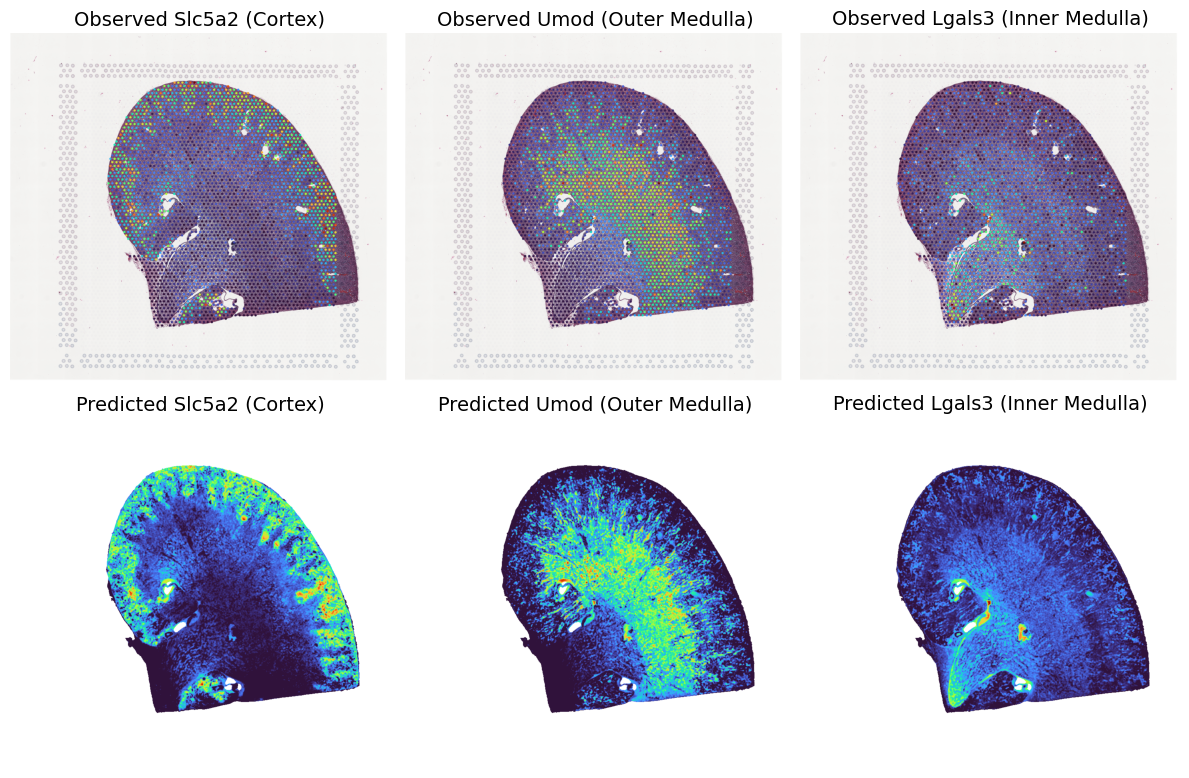

In [2]:
#| hide
import matplotlib.pyplot as plt
from PIL import Image

# Load observed and predicted images
slc5a2_obs = Image.open('spots/Slc5a2.png')
slc5a2_pred = Image.open('cnts-super-plots/Slc5a2.png')
umod_obs = Image.open('spots/Umod.png')
umod_pred = Image.open('cnts-super-plots/Umod.png')
lgals3_obs = Image.open('spots/Lgals3.png')
lgals3_pred = Image.open('cnts-super-plots/Lgals3.png')

# Create a figure with 6 subplots (2 rows, 3 columns)
plt.figure(figsize=(12, 8))

# Top row: Observed gene expression
plt.subplot(2, 3, 1)
plt.imshow(slc5a2_obs)
plt.axis('off')
plt.title("Observed Slc5a2 (Cortex)", fontsize=14)

plt.subplot(2, 3, 2)
plt.imshow(umod_obs)
plt.axis('off')
plt.title("Observed Umod (Outer Medulla)", fontsize=14)

plt.subplot(2, 3, 3)
plt.imshow(lgals3_obs)
plt.axis('off')
plt.title("Observed Lgals3 (Inner Medulla)", fontsize=14)

# Bottom row: Predicted gene expression
plt.subplot(2, 3, 4)
plt.imshow(slc5a2_pred)
plt.axis('off')
plt.title("Predicted Slc5a2 (Cortex)", fontsize=14)

plt.subplot(2, 3, 5)
plt.imshow(umod_pred)
plt.axis('off')
plt.title("Predicted Umod (Outer Medulla)", fontsize=14)

plt.subplot(2, 3, 6)
plt.imshow(lgals3_pred)
plt.axis('off')
plt.title("Predicted Lgals3 (Inner Medulla)", fontsize=14)

# Adjust layout
plt.tight_layout()
plt.show()


### 5. Segmentation

The segmentation process uses the second-to-last layer of the trained feed-forward neural network as embeddings. To improve spatial continuity and reduce noise, these embeddings are smoothed using a Gaussian filter with an 8-pixel filter size, as illustrated in the comparison of smoothed and unsmoothed embeddings below. KMeans clustering with 10 clusters is applied to segment the tissue. Connected component analysis further refines the segmentation by merging small or isolated regions smaller than 20 pixels with adjacent larger clusters, preventing over-segmentation and promoting cohesive, biologically meaningful clusters.

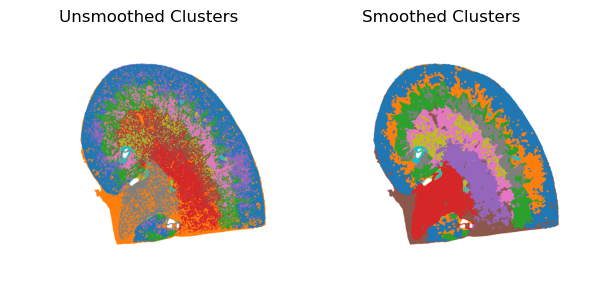

In [5]:
#| hide
unsmoothed_img = Image.open('clusters-gene/unsmoothed/nclusters010/labels.png')
smoothed_img = Image.open('clusters-gene/labels.png')

plt.figure(figsize=(6, 3))

# Unsmoothed image
plt.subplot(1, 2, 1)
plt.imshow(unsmoothed_img)
plt.axis('off')
plt.title("Unsmoothed Clusters")

# Smoothed image
plt.subplot(1, 2, 2)
plt.imshow(smoothed_img)
plt.axis('off')
plt.title("Smoothed Clusters")

plt.tight_layout()
plt.show()

### References

Zhang, D., Schroeder, A., Yan, H., Yang, H., Hu, J., Lee, M. Y., ... & Li, M. (2024). Inferring super-resolution tissue architecture by integrating spatial transcriptomics with histology. Nature biotechnology, 1-6. 

Clark, J. Z., Chen, L., Chou, C. L., Jung, H. J., Lee, J. W., & Knepper, M. A. (2019). Representation and relative abundance of cell-type selective markers in whole-kidney RNA-Seq data. Kidney international, 95(4), 787-796.